<a href="https://colab.research.google.com/github/Tstrebe2/predicting-text-difficulty/blob/josh-updates/josh-AoA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [80]:
# import sys
import pandas as pd
import numpy as np
import spacy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import clean_wiki as cw  # custom cleaning module

# installers
# !{sys.executable} -m pip install pyspark -q
# !{sys.executable} -m pip install -U spacy -q
# !{sys.executable} -m spacy download en_core_web_lg -q
# !{sys.executable} -m pip install sklearn -q

In [81]:
n = 10000  # sample size (number if > 1 else fraction)

grade_level = [   # school level by age
    (3, 4, 0, 'Foundation'),
    (4, 5, 0, 'Foundation'),
    (5, 6, 1, 'Primary'),
    (6, 7, 1, 'Primary'),
    (7, 8, 1, 'Primary'),
    (8, 9, 1, 'Primary'),
    (9, 10, 1, 'Primary'),
    (10, 11, 1, 'Primary'),
    (11, 12, 2, 'MiddleSchool'),
    (12, 13, 2, 'MiddleSchool'),
    (13, 14, 2, 'MiddleSchool'),
    (14, 15, 3, 'IGCSE'),
    (15, 16, 3, 'IGCSE'),
    (16, 17, 3, 'IB'),
    (17, 18, 3, 'IB'),
    (19, 200, 3, 'College')
]

def grade_finder(age):
  for i in grade_level:
    if i[0] <= age <= i[1]:
      return i[2]
  return -1

## Dataset

In [82]:
df = cw.process_file('WikiLarge_Train.csv')
df.head()

root
 |-- original_text: string (nullable = true)
 |-- label: string (nullable = true)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|original_text                                                                                                                                                                                                                                           |label|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|There is manuscript evidence that Austen continued to work on these pieces as late as the period 1809 â '' 11 , and that her niece and nephe

,original_text,label
0,There is manuscript evidence that Austen conti...,1
1,"In a remarkable comparative analysis , Mandaea...",1
2,"Before Persephone was released to Hermes , who...",1
3,Cogeneration plants are commonly found in dist...,1
4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",1


In [83]:
df_sample = df.sample(n) if n >= 1 else df.sample(frac=n)

## Lemmatize (and then some)

In [84]:
nlp = spacy.load('en_core_web_lg')
tokens = []
for doc in nlp.pipe(df_sample['original_text'], n_process=4):
  tokens.append([w.lemma_ for w in doc])

In [85]:
df_AoA = pd.read_csv('AoA_51715_words.csv', encoding= 'unicode_escape')

# load words and ages into dictionary
age = {}
for _, w in df_AoA.iterrows():
  age[w[0]] = w[10]
  if w[0] != w[1]:
    age[w[1]] = w[10]

df_AoA.sample(10)

,Word,Alternative.spelling,Freq_pm,Dom_PoS_SUBTLEX,Nletters,Nphon,Nsyll,Lemma_highest_PoS,AoA_Kup,Perc_known,AoA_Kup_lem,Perc_known_lem,AoA_Bird_lem,AoA_Bristol_lem,AoA_Cort_lem,AoA_Schock
50670,wheels,wheels,13.29,Noun,6,4,1,wheel,NaN,NaN,4.40,1.00,NaN,4.47,4.93,NaN
45383,tackiness,tackiness,0.02,Noun,9,7,3,tackiness,9.68,1.00,9.68,1.00,NaN,NaN,NaN,NaN
40543,sentence,sentence,20.53,Noun,8,7,2,sentence,5.84,1.00,5.84,1.00,6.53,NaN,NaN,5.74
11008,cryptic,cryptic,1.04,Adjective,7,7,2,cryptic,11.78,1.00,11.78,1.00,NaN,NaN,NaN,12.22
19324,gem,gem,2.47,Noun,3,3,1,gem,7.68,1.00,7.68,1.00,NaN,NaN,6.87,NaN
46593,tiresome,tiresome,1.45,Adjective,8,6,3,tiresome,8.42,1.00,8.42,1.00,NaN,NaN,NaN,NaN
17271,fiancee,fiance,3.02,Noun,7,6,3,fiancee,8.47,1.00,8.47,1.00,NaN,NaN,NaN,NaN
50438,wayfaring,wayfaring,0.02,Adjective,9,7,3,wayfaring,13.88,0.81,13.88,0.81,NaN,NaN,NaN,NaN
48658,unlatch,unlatch,0.06,Verb,7,5,2,unlatch,8.53,1.00,8.53,1.00,NaN,NaN,NaN,NaN
39261,rusher,rusher,0.02,Noun,6,4,2,rusher,10.35,0.89,10.35,0.89,NaN,NaN,NaN,NaN


## Basic Features

In [86]:
df_sample.head()

,original_text,label
230661,"Tourism was , and continues to be one of the m...",0
130112,"In 1892 , she was given the medal Illis Quorum...",1
162154,Abel Tasman is the next documented explorer to...,1
48957,"According to the United States Census Bureau ,...",1
124346,As a Khalifa or Caliph he was not a monarch an...,1


In [87]:
# Basic stats
df_sample['num_lemmas'] = [len(s) for s in tokens]
df_sample['min_age'] = [np.nanmin([age.get(w, np.nan) for w in s]) for s in tokens]
df_sample['mean_age'] = [np.nanmean([age.get(w, np.nan) for w in s]) for s in tokens]
df_sample['max_age'] = [np.nanmax([age.get(w, np.nan) for w in s]) for s in tokens]
df_sample['num_listed'] = [len([w for w in s if age.get(w,0) > 0]) for s in tokens]
df_sample['num_unlisted'] = df_sample['num_lemmas'] - df_sample['num_listed']

# Grade level
df_sample['grade_min_age'] = df_sample['min_age'].apply(lambda x: grade_finder(x))
df_sample['grade_mean_age'] = df_sample['mean_age'].apply(lambda x: grade_finder(x))
df_sample['grade_max_age'] = df_sample['max_age'].apply(lambda x: grade_finder(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: All-NaN axis encountered
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: All-NaN axis encountered
  """


## Feature Statistics

In [88]:
means = df_sample.mean()
sdevs = df_sample.std()

mdict = {}
for m in means:
  mdict[means[means==m].index[0]] = m

sdict = {}
for s in sdevs:
  sdict[sdevs[sdevs==s].index[0]] = s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


## Z-Score Features

In [89]:
for c in df_sample.columns[2:8]:
  df_sample[f'z_{c}'] = (df_sample[c] - means[c]) / sdevs[c]

df_sample.head()

,original_text,label,num_lemmas,min_age,mean_age,max_age,num_listed,num_unlisted,grade_min_age,grade_mean_age,grade_max_age,z_num_lemmas,z_min_age,z_mean_age,z_max_age,z_num_listed,z_num_unlisted
230661,"Tourism was , and continues to be one of the m...",0,18,3.23,6.465000,13.05,16,2,0,1,2,-0.430343,-0.172128,0.987473,1.153182,0.182778,-1.045574
130112,"In 1892 , she was given the medal Illis Quorum...",1,17,3.57,4.760000,6.83,9,8,0,0,1,-0.509975,0.286457,-0.970816,-1.250128,-0.602400,-0.153649
162154,Abel Tasman is the next documented explorer to...,1,17,3.69,5.295385,9.86,13,4,0,1,1,-0.509975,0.448311,-0.355897,-0.079384,-0.153727,-0.748266
48957,"According to the United States Census Bureau ,...",1,54,2.37,5.162222,9.65,27,27,-1,1,1,2.436432,-1.332079,-0.508841,-0.160524,1.416631,2.670781
124346,As a Khalifa or Caliph he was not a monarch an...,1,24,2.89,5.421429,12.24,21,3,-1,1,2,0.047453,-0.630713,-0.211128,0.840211,0.743621,-0.896920


## Feature Importance

In [90]:
# Nan's break the model
df_clean = df_sample.dropna()

In [91]:
X = df_clean[df_clean.columns[2:]]
y = df_clean['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [92]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [93]:
Lasso().get_params().keys()

dict_keys(['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'normalize', 'positive', 'precompute', 'random_state', 'selection', 'tol', 'warm_start'])

In [94]:
pipeline = Pipeline([('model',Lasso(random_state=42))])
search = GridSearchCV(pipeline,{'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5, scoring="neg_mean_squared_error", verbose=0)
search.fit(X_train,y_train)
search.best_params_

{'model__alpha': 0.1}

In [95]:
coefficients = search.best_estimator_.named_steps['model'].coef_
importance = np.abs(coefficients)
print(importance)

[0.0069607  0.         0.         0.01358742 0.         0.0013386
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]


In [96]:
np.array(df_clean.columns[2:])[importance > 0]

array(['num_lemmas', 'max_age', 'num_unlisted'], dtype=object)

## Regression

In [97]:
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.60      0.59      0.59       941
           1       0.63      0.64      0.63      1034

    accuracy                           0.62      1975
   macro avg       0.61      0.61      0.61      1975
weighted avg       0.62      0.62      0.62      1975



In [98]:
scaler = StandardScaler()
scaler.fit(X_train)
X_scaled = scaler.transform(X_train)

In [99]:
pca = PCA(n_components=X_scaled.shape[1], random_state=42)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)
np.cumsum(pca.explained_variance_ratio_ * 100)

array([ 38.4321079 ,  66.42298712,  82.64485933,  90.47297742,
        94.68260143,  97.67129789,  98.96484333, 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        ])

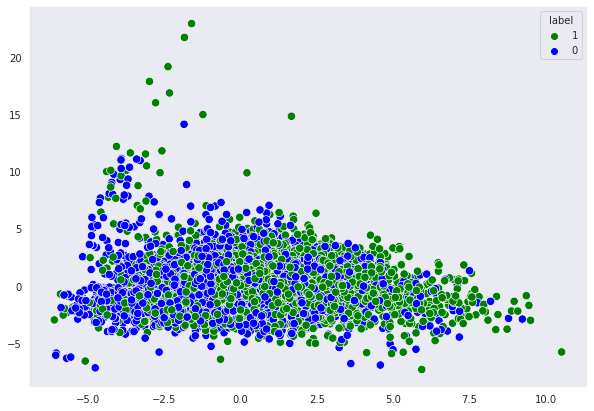

In [108]:
plt.figure(figsize=(10,7))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], s=70, hue=y_train, palette=['green','blue'])
plt.show()

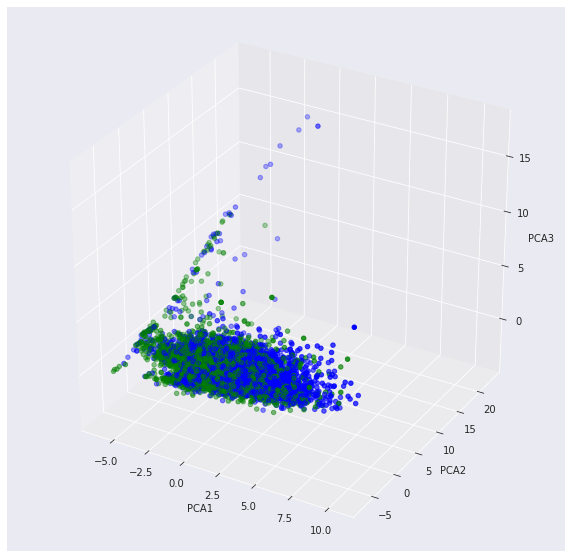

In [129]:
sns.set_style("darkgrid", {'axes.grid' : False})

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=['green' if i=='0' else 'blue' for i in y_train], marker='o')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')

plt.show()

In [137]:
import collections
collections.Counter(y_train)


Counter({'1': 4048, '0': 3849})